# Vision Transformer (ViT) 기반 이미지 분류 실습 노트

## 1) 소개 (Introduction)

**Vision Transformer (ViT)**는 이미지를 작은 패치(patch)들로 분할하여, 마치 NLP의 단어 토큰처럼 처리하는 Transformer 기반 모델입니다.  
ViT는 2020년 Google 연구진에 의해 제안되었으며, 충분히 큰 데이터셋에서 **합성곱 신경망(CNN)**에 필적하거나 뛰어난 성능을 보이는 것으로 알려져 있습니다.


---
※ 이미지 분류를 위한 트랜스포머 (Vision Transformers)

트랜스포머(Transformers)는 원래 **집합(set) 데이터를 처리**하기 위한 구조로 제안되었습니다.  
이는 입력의 순서를 바꾸더라도 출력이 동일하게 바뀌는, 즉 **순열 등변(permutation-equivariant)** 특성을 갖기 때문입니다.  
이러한 트랜스포머 구조를 시퀀스(예: 문장)에 적용할 때는, 단순히 입력 벡터에 **포지셔널 인코딩(position encoding)**을 추가하면 됩니다.  
그 후 모델은 스스로 그 정보를 활용하는 방법을 학습하게 됩니다.

그렇다면 이미지를 시퀀스처럼 다루면 어떨까요?  
바로 이 아이디어를 기반으로 [Alexey Dosovitskiy 외 연구진](https://openreview.net/pdf?id=YicbFdNTTy)은  
논문 *“An Image is Worth 16x16 Words”* 에서 **Vision Transformer (ViT)** 구조를 제안했습니다.

이 모델은 이미지를 **작은 패치(patch)**로 나눈 후,  
각 패치를 하나의 단어(word) 또는 토큰(token)처럼 간주하여 트랜스포머에 입력합니다.  
예를 들어, $32 \times 32$ 크기의 이미지를 $4 \times 4$ 크기의 패치로 분할하면 총 $64$개의 패치(토큰)가 생성됩니다.  
각 패치는 고차원 임베딩 공간으로 변환되고,  
분류를 위한 특수 토큰(class token)과 포지셔널 인코딩을 추가한 후 일반적인 트랜스포머 구조에 입력됩니다.

아래 GIF는 Vision Transformer의 전체 구조를 직관적으로 보여줍니다  
(출처: [Phil Wang](https://github.com/lucidrains/vit-pytorch/blob/main/images/vit.gif)):

<center width="100%">
<img src="https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial15/vit.gif?raw=1" width="600px">
</center>

---


이 노트북에서는 다음 두 가지 실습을 단계적으로 진행합니다:

1. **ViT 모델 직접 구현 (from scratch)**  
   - PyTorch로 ViT 구조를 직접 구현하고, 작은 이미지 데이터셋에 대해 학습 및 테스트합니다.  
   - 이를 통해 Patch Embedding, Position Embedding, Transformer Encoder 등 ViT의 내부 구조를 이해합니다.

2. **사전학습(pre-trained) 모델 활용**  
   - Hugging Face 🤗 Transformers 라이브러리를 사용해 사전학습된 ViT 모델을 불러옵니다.  
   - 적은 양의 데이터로도 높은 성능을 얻기 위한 **미세조정(fine-tuning)**을 실습합니다.

두 단계 모두 **Google Colab** 환경에서 실행 가능하도록 구성되어 있으며, 다음과 같은 특징을 포함합니다:

- 각 단계마다 **마크다운 설명 + 코드 블록**을 교차 배치해 개념을 직관적으로 설명하고 즉시 실습이 가능하도록 구성
- **Patch Embedding**, **Class Token**, **Position Embedding**, **Multi-Head Self-Attention** 등 핵심 개념에 대한 상세 설명
- **훈련 결과 시각화**: 손실/정확도 곡선, Attention Map 시각화를 통해 ViT의 학습 과정을 확인

> 💡 **Note:**  
> Colab에서 실행할 경우 **GPU 런타임** 사용을 권장합니다.  
> `런타임 > 런타임 유형 변경 >하드웨어 가속기 > GPU` 메뉴에서 설정하세요.  


## 2) 환경 설정 (Environment Setup)

먼저 실습에 필요한 주요 라이브러리들을 설치합니다.  
- **PyTorch**: torch, torchvision  
- **Hugging Face Transformers**: 사전학습된 ViT 모델 사용  
- **Datasets**: Hugging Face의 데이터셋 불러오기

> 💡 Colab 환경에는 일부 패키지가 이미 설치되어 있습니다.

필요한 모듈들을 임포트하고, 사용 가능한 디바이스(CPU/GPU)를 확인합니다:

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchvision

# 사용 가능한 디바이스 (GPU가 있으면 GPU 사용)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

Using device: cuda


## 3) 데이터셋 준비 및 분석 (Dataset Preparation)

이번 실습에서는 **CIFAR-10** 데이터셋을 사용합니다.  
CIFAR-10은 10개의 카테고리(예: 비행기, 자동차, 새, 고양이 등)로 이루어진 컬러 이미지 데이터셋으로,  
훈련 이미지 50,000장과 테스트 이미지 10,000장으로 구성되어 있습니다.  
이미지 크기는 작게 (32×32 픽셀) 정규화되어 있어 실습용으로 적합합니다.

<br>

우리는 `torchvision`을 통해 CIFAR-10을 불러올 것입니다.  
**데이터 증강(data augmentation)**과 전처리를 위해 `torchvision.transforms`를 사용합니다.

모델을 처음부터 학습하는 **1단계**에서는 이미지 크기 32×32를 그대로 사용하고,  
수평 뒤집기 등 약간의 증강을 적용합니다.  

**2단계**의 사전학습 모델 활용 시에는 해당 모델이 학습된 해상도  
(ViT-base의 경우 224×224)에 맞게 이미지를 **확대(resize)**할 예정입니다.

<br>

우선 CIFAR-10 훈련셋과 테스트셋을 로드하고,  
1단계 실습을 위한 변환기를 정의하겠습니다.

In [ ]:
# CIFAR-10 데이터셋 다운로드 및 로드
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True)

# 클래스 이름 (라벨) 목록
classes = train_dataset.classes
print("클래스:", classes)
print("훈련 이미지 개수:", len(train_dataset), "/ 테스트 이미지 개수:", len(test_dataset))

# 1단계: ViT를 처음부터 학습할 때 사용할 데이터 변환기
# - 학습 시: 약간의 데이터 증강 (좌우반전, 주변에 약간 패딩후 랜덤 크롭) 적용
# - 테스트 시: 이미지 크기만 맞추고 Normalize
train_transform_stage1 = transforms.Compose([
    transforms.RandomCrop(32, padding=4),      # 4픽셀 패딩 후 32x32 랜덤크롭
    transforms.RandomHorizontalFlip(),         # 랜덤 좌우반전
    transforms.ToTensor(),                     # PIL 이미지 -> Tensor 변환
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))  # 0~1 -> -1~1 정규화
])
test_transform_stage1 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

# 변환기 설정을 데이터셋에 적용
train_dataset.transform = train_transform_stage1
test_dataset.transform = test_transform_stage1

# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

클래스: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
훈련 이미지 개수: 50000 / 테스트 이미지 개수: 10000


위 변환에서 `Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))`는  
각 채널(R, G, B)의 픽셀값을 평균 0.5, 표준편차 0.5로 정규화하여 **[-1, 1] 범위**로 변환합니다.  


이는 **2단계에서 사용할 사전학습 ViT 모델의 전처리 방식과도 일치**합니다.

훈련 데이터 일부를 시각화하여, 이미지와 해당 레이블을 확인해보겠습니다.

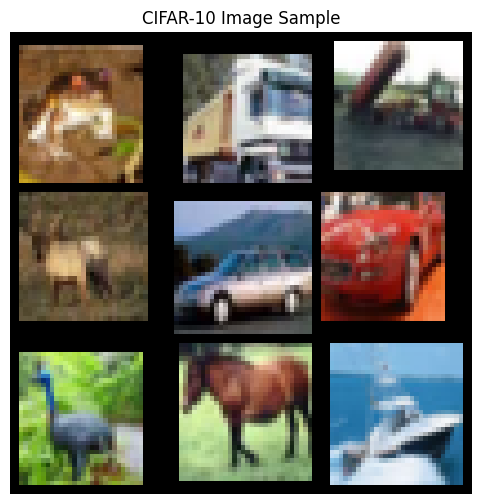

label: ['frog', 'truck', 'truck', 'deer', 'automobile', 'automobile', 'bird', 'horse', 'ship']


In [ ]:
import matplotlib.pyplot as plt

# 훈련 데이터에서 처음 9개 이미지와 라벨 표시
samples, labels = next(iter(DataLoader(train_dataset, batch_size=9)))
samples = samples / 2 + 0.5  # Normalize를 역변환 ([-1,1] -> [0,1])
grid_img = torchvision.utils.make_grid(samples, nrow=3)
plt.figure(figsize=(6,6))
plt.imshow(grid_img.permute(1, 2, 0))
plt.axis('off')
plt.title("CIFAR-10 Image Sample")
plt.show()

print("label:", [classes[label] for label in labels])

이번에는 이 이미지를 트랜스포머의 입력을 위해 패치로 어떻게 나눠지는지 확인해보겠습니다.

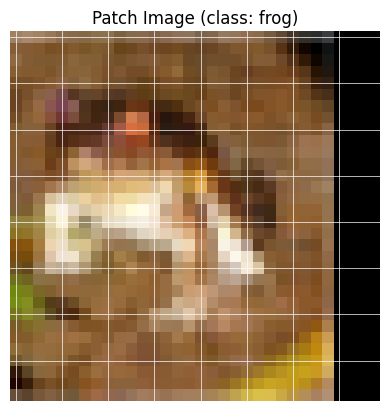

In [ ]:
# 예시 이미지 하나 선택 (정규화 해제)
image, label = train_dataset[0]
image = image / 2 + 0.5  # Normalize 역변환
img_np = image.permute(1, 2, 0).numpy()

# 패치 크기 설정 (ViT 기준: 4x4)
patch_size = 4
fig, ax = plt.subplots()
ax.imshow(img_np)
ax.set_title(f"Patch Image (class: {classes[label]})")

# 패치 경계선 그리기
h, w = img_np.shape[:2]
for y in range(0, h, patch_size):
    ax.axhline(y, color='white', linewidth=0.5)
for x in range(0, w, patch_size):
    ax.axvline(x, color='white', linewidth=0.5)

plt.axis('off')
plt.show()

원본 이미지를 직접 볼 때와 비교하면, 패치로 나눈 이미지를 통해 물체를 인식하는 것은 훨씬 어렵습니다.  
그럼에도 불구하고, 이러한 패치 시퀀스는 우리가 트랜스포머(Transformer)에 입력으로 제공하는 형태입니다.  
모델은 학습을 통해 **어떻게 패치들을 결합해야 전체 이미지를 이해할 수 있는지 스스로 학습해야 합니다.**

기존 CNN은 **이미지가 픽셀의 격자(grid)**라는 inductive bias(귀납적 가정)를 내재하고 있습니다.  
그러나 ViT는 이 inductive bias 없이 작동하기 때문에, 학습 데이터에 따라 더 유연하거나 더 어렵게 작동할 수 있습니다.

---

패치 전처리 과정을 이해했으니, 이제 **Transformer 모델을 본격적으로 구현**해보겠습니다.  

## 4) ViT 모델 구조 이해 (Understanding ViT Architecture)

ViT의 전체 구조를 간략히 정리하면 다음과 같습니다:

- **Patch Embedding (패치 임베딩)**:  
  입력 이미지를 고정 크기의 패치로 나누고(flatten), 각각을 임베딩 벡터로 변환합니다.  
  예를 들어, 32×32 이미지를 4×4 패치로 나누면 총 64개의 패치가 생성됩니다.  
  각 패치는 3채널(컬러)이므로 (3×4×4)의 차원을 가지며, 이를 선형 계층이나 합성곱 등을 통해 지정된 차원(예: 128차원)의 벡터로 임베딩합니다.

- **[CLS] Class Token (분류 토큰)**:  
  Transformer 입력 시퀀스의 맨 앞에 추가되는 학습 가능한 토큰입니다.  
  이 토큰은 인코더를 통과하면서 전체 이미지 정보를 요약하게 되며,  
  최종적으로 이 토큰의 출력을 분류 헤드에 입력하여 클래스 예측을 수행합니다.  
  (BERT 등 NLP 모델에서 사용되는 [CLS] 토큰과 유사한 개념입니다.)

- **Position Embedding (위치 임베딩)**:  
  Transformer는 순서 개념이 없기 때문에, 패치의 위치 정보를 더해줘야 합니다.  
  ViT에서는 학습 가능한 위치 임베딩 벡터를 패치 토큰들과 클래스 토큰에 더해줌으로써  
  토큰의 순서와 공간 정보를 모델에 주입합니다.

- **Transformer Encoder Blocks**:  
  여러 개의 인코더 블록으로 구성되며, 각 블록은  
  **멀티헤드 자기어텐션(Multi-Head Self-Attention)** 층과  
  **피드포워드 네트워크(FFN)**로 구성되어 있습니다.  
  자기어텐션은 모든 패치 간 관계를 attention mechanism으로 계산하고,  
  FFN은 각 위치에 독립적으로 비선형 변환을 적용합니다.  
  각 서브층 뒤에는 **잔차 연결(skip connection)**과 **Layer Normalization**이 적용되며,  
  이러한 블록이 L번(예: 6층, 12층 등) 반복됩니다.

- **Classification Head (분류 헤드)**:  
  Transformer 인코더의 출력 중 클래스 토큰에 해당하는 은닉 상태(hidden state)를 꺼내어,  
  이를 선형 분류기에 통과시켜 각 클래스에 대한 확률을 출력합니다.  
  학습 시에는 소프트맥스-크로스엔트로피 손실 함수를 사용하여 정답과의 오차를 최소화하도록 모델을 학습시킵니다.

이제 이러한 구성을 실제 PyTorch 모델로 구현해보겠습니다.

## 5) 1단계: ViT 모델 PyTorch로 구현 및 학습 (Implementing ViT from Scratch)

### (1) ViT 모델 구현 (Implementing the ViT Model in PyTorch)

아래에서 설명한 ViT 구조를 그대로 `nn.Module` 형태로 구현합니다.  
주요 구성 요소는 다음과 같습니다:

- **1) Patch Embedding 계층**:  
  합성곱(conv2d)을 사용하여 이미지를 패치 단위로 분할하고 임베딩합니다.  
  커널 크기와 스트라이드를 패치 크기로 설정하면, 이미지를 자동으로 패치 단위로 자르고  
  각 패치를 벡터로 변환하는 효과를 얻을 수 있습니다.  
  출력 텐서는 (batch, embed_dim, num_patches_h, num_patches_w) 형태이며,  
  이를 flatten하여 (batch, num_patches, embed_dim) 시퀀스로 변환합니다.

- **2) Class Token & Position Embedding**:  
  학습 가능한 클래스 토큰과 위치 임베딩을 `nn.Parameter`로 정의합니다.  
  클래스 토큰은 (1, 1, embed_dim) 크기로,  
  위치 임베딩은 (1, num_patches + 1, embed_dim) 크기로 정의합니다.  
  Forward 시 클래스 토큰을 배치 크기만큼 복제하여 입력 시퀀스 앞에 붙이고,  
  위치 임베딩을 더해줍니다.

- **3) Multi-Head Self-Attention & MLP 블록**:  
  PyTorch의 `nn.MultiheadAttention`을 사용해 멀티헤드 어텐션을 구현합니다.  
  어텐션 출력에는 Residual 연결을 적용하고, LayerNorm을 사용합니다.  
  이어서 두 개의 선형 계층과 GELU 활성화를 포함한 MLP를 적용하고,  
  역시 Residual + LayerNorm 구조로 구성합니다.  
  이러한 블록은 depth 횟수만큼 반복됩니다.

- **4) 최종 분류층**:  
  인코더 출력 중 클래스 토큰 위치의 벡터(x[:, 0])를 추출하여,  
  Linear 레이어를 통과시켜 `num_classes` 차원의 분류 결과를 생성합니다.

In [ ]:
class ViT(nn.Module):
    def __init__(self, image_size=32, patch_size=4, num_classes=10,
                 embed_dim=128, depth=6, num_heads=8, mlp_dim=256, dropout=0.1):
        super(ViT, self).__init__()
        assert image_size % patch_size == 0, "이미지 크기는 패치 크기로 나누어 떨어져야 합니다."
        self.image_size = image_size
        self.patch_size = patch_size
        self.num_patches = (image_size // patch_size) ** 2  # 패치 개수

        # 1. Patch Embedding: Conv2d로 이미지 -> 패치임베딩 (출력 채널=embed_dim, 커널=패치크기, 스트라이드=패치크기)
        self.patch_embed = nn.Conv2d(in_channels=3, out_channels=embed_dim,
                                     kernel_size=patch_size, stride=patch_size)

        # 2. Class token과 Position Embedding 정의
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))               # [1,1,embed_dim]
        self.pos_embed = nn.Parameter(torch.randn(1, 1 + self.num_patches, embed_dim))  # [1, num_patches+1, embed_dim]
        # train 되는 POS임
        self.pos_drop = nn.Dropout(dropout)

        # 3. Transformer Encoder blocks
        self.blocks = nn.ModuleList([
            nn.ModuleDict({
                "norm1": nn.LayerNorm(embed_dim),
                "attn": nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=True),
                "norm2": nn.LayerNorm(embed_dim),
                "mlp": nn.Sequential(
                    nn.Linear(embed_dim, mlp_dim),
                    nn.GELU(),
                    nn.Dropout(dropout),
                    nn.Linear(mlp_dim, embed_dim),
                    nn.Dropout(dropout),
                )
            })
            for _ in range(depth)
        ])

        # 4. 최종 LayerNorm 및 출력 분류 Linear
        self.final_norm = nn.LayerNorm(embed_dim)
        self.classifier = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        # 입력 x: [batch, 3, 32, 32]
        batch_size = x.size(0)
        # Patch embedding: Conv로 패치 추출 및 임베딩 -> shape: [batch, embed_dim, H/patch, W/patch]
        x = self.patch_embed(x)                        # [batch, embed_dim, 8, 8] (예: 32/4=8), [배치, 워드, 시퀀스 순 바꿔줘함]
        # 위에 conv 통과
        x = x.flatten(2).transpose(1, 2)               # [batch, num_patches, embed_dim]

        # 클래스 토큰을 배치 개수만큼 복제하여 앞에 붙임
        cls_tokens = self.cls_token.expand(batch_size, 1, -1)  # [batch, 1, embed_dim]
        x = torch.cat((cls_tokens, x), dim=1)  # [batch, 1+num_patches, embed_dim]

        # 위치 임베딩 추가
        x = x + self.pos_embed[:, :x.size(1), :]
        x = self.pos_drop(x)

        # Transformer 인코더 블록들을 순차적으로 적용
        for block in self.blocks:
            # Multi-head Self-Attention
            # LayerNorm + Attention
            x = block["norm1"](x)
            attn_out, _ = block["attn"](x, x, x, need_weights=False)  # self-attention
            x = x + attn_out  # residual connection
            # MLP
            x = block["norm2"](x)
            mlp_out = block["mlp"](x)
            x = x + mlp_out   # residual connection

        # 최종 LayerNorm
        x = self.final_norm(x)
        # x의 첫 번째 토큰 (cls token 위치)만 추출하여 분류
        cls_token_final = x[:, 0]               # [batch, embed_dim]
        out = self.classifier(cls_token_final)  # [batch, num_classes]
        return out

> 💡 **구현 참고:**  
> 위 구현은 이해를 돕기 위해 **LayerNorm**과 **Residual 연결**을 명시적으로 작성하였습니다.  
> 성능을 더 높이고자 한다면, Residual의 전후 순서나 세부 구성 방식,  
또는 PyTorch의 `torch.nn.TransformerEncoder` 모듈을 활용하는 것도 가능합니다.




그러나 현재 방식으로도 ViT의 기본 동작을 충분히 실습하고 이해하는 데에는 무리가 없습니다.

이제 모델을 초기화하고, GPU를 사용할 경우 `.to(device)`를 이용해 모델을 해당 디바이스로 이동시켜줍니다.

In [ ]:
# ViT 모델 인스턴스 생성 (임베딩차원 128, 인코더 블록 6개 등)
model = ViT(image_size=32, patch_size=4, num_classes=10,
            embed_dim=128, depth=6, num_heads=8, mlp_dim=256, dropout=0.1).to(device)
print("모델 생성 완료!")

모델 생성 완료!


### (2) 학습 설정 및 진행 (Training the ViT Model)

모델을 학습하기 위해 필요한 **손실 함수**와 **최적화 알고리즘**을 설정합니다.

- 이 실습은 **분류 문제**이므로, 손실 함수로는 `nn.CrossEntropyLoss`를 사용합니다.
- 최적화 알고리즘으로는 **Adam**을 사용하며, 초기 학습률은 `1e-3`로 설정합니다.

모델 규모가 작기 때문에, **러닝레이트 스케줄러나 웜업(warm-up)** 없이도  
학습이 원활히 수렴할 것으로 예상됩니다.  
(필요에 따라 스케줄러 등을 추가하여 성능을 개선할 수 있습니다.)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

이제 **훈련 루프(training loop)**를 작성합니다.  
약 20 epoch 정도 반복하며, 매 epoch마다 전체 훈련 데이터를 한 번씩 모두 학습시킵니다.

각 epoch에서는 다음 과정을 반복합니다:

1. 모델에 입력을 주고 출력을 얻습니다.
2. 출력 결과와 실제 정답을 비교하여 **손실(loss)**을 계산합니다.
3. `optimizer.zero_grad()`를 호출하여 이전 단계의 그래디언트를 초기화합니다.
4. `loss.backward()`를 호출하여 **오류역전파(backpropagation)**를 수행합니다.
5. `optimizer.step()`을 호출하여 모델 파라미터를 업데이트합니다.

이 과정을 미니배치 단위로 수행하며,  
각 epoch이 끝날 때마다 다음 항목을 출력하여 학습 진행 상황을 모니터링합니다:

- 훈련 평균 손실  
- 훈련 정확도  
- 테스트(검증) 손실  
- 테스트(검증) 정확도

In [ ]:
epochs = 20
train_losses, train_accs = [], []
val_losses, val_accs = [], []

for epoch in range(1, epochs+1):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        # 순전파 및 손실 계산
        outputs = model(images)
        loss = criterion(outputs, labels)
        # 역전파 및 최적화
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # 통계 기록
        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    # 에포크별 평균 손실 및 정확도
    train_loss = running_loss / total
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # 검증 (테스트 데이터 성능 측정)
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    val_loss = val_loss / val_total
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    # Epoch 결과 출력
    print(f"[Epoch {epoch}/{epochs}] "
          f"훈련 손실: {train_loss:.3f}, 훈련 정확도: {train_acc*100:.2f}% | "
          f"테스트 손실: {val_loss:.3f}, 테스트 정확도: {val_acc*100:.2f}%")

[Epoch 1/20] 훈련 손실: 1.889, 훈련 정확도: 30.08% | 테스트 손실: 1.603, 테스트 정확도: 42.55%
[Epoch 2/20] 훈련 손실: 1.592, 훈련 정확도: 41.90% | 테스트 손실: 1.408, 테스트 정확도: 49.65%
[Epoch 3/20] 훈련 손실: 1.476, 훈련 정확도: 46.69% | 테스트 손실: 1.320, 테스트 정확도: 52.94%
[Epoch 4/20] 훈련 손실: 1.399, 훈련 정확도: 49.37% | 테스트 손실: 1.265, 테스트 정확도: 54.61%
[Epoch 5/20] 훈련 손실: 1.336, 훈련 정확도: 51.88% | 테스트 손실: 1.257, 테스트 정확도: 54.66%
[Epoch 6/20] 훈련 손실: 1.292, 훈련 정확도: 53.49% | 테스트 손실: 1.225, 테스트 정확도: 56.71%
[Epoch 7/20] 훈련 손실: 1.244, 훈련 정확도: 55.11% | 테스트 손실: 1.143, 테스트 정확도: 58.42%
[Epoch 8/20] 훈련 손실: 1.210, 훈련 정확도: 56.59% | 테스트 손실: 1.171, 테스트 정확도: 57.78%
[Epoch 9/20] 훈련 손실: 1.169, 훈련 정확도: 57.87% | 테스트 손실: 1.097, 테스트 정확도: 61.08%
[Epoch 10/20] 훈련 손실: 1.141, 훈련 정확도: 59.02% | 테스트 손실: 1.065, 테스트 정확도: 61.96%
[Epoch 11/20] 훈련 손실: 1.105, 훈련 정확도: 60.53% | 테스트 손실: 1.062, 테스트 정확도: 62.38%
[Epoch 12/20] 훈련 손실: 1.081, 훈련 정확도: 61.39% | 테스트 손실: 1.019, 테스트 정확도: 63.78%
[Epoch 13/20] 훈련 손실: 1.056, 훈련 정확도: 62.58% | 테스트 손실: 1.056, 테스트 정확도: 62.80%
[Epoch 14/20] 훈련 손실: 

훈련 과정을 출력해보면, epoch가 거듭될수록  
**훈련 손실과 검증 손실이 점차 감소**하고,  
**정확도는 상승**하는 경향을 확인할 수 있습니다.

<br>

초기에는 모델이 무작위로 예측하기 때문에  
정확도가 약 **40% 수준**(10개 클래스 중 임의 선택)에서 시작하지만,  
학습이 진행될수록 성능이 점점 향상됩니다.

<br>

훈련이 완료된 후에는 **최종 테스트셋에 대한 정확도**를 출력하여  
모델이 실제로 얼마나 잘 일반화되었는지를 확인합니다.

In [ ]:
print("최종 테스트 정확도: {:.2f}%".format(val_accs[-1]*100))

최종 테스트 정확도: 67.75%


### (3) 결과 시각화 및 해석 (Results and Visualization)

훈련 과정에서 기록한 **손실(loss)**과 **정확도(accuracy)**의 변화를  
그래프로 시각화해 보겠습니다.

이러한 시각화는 다음과 같은 측면에서 유용합니다:

- 모델이 **과소적합**되고 있는지  
- 모델이 **과적합**되고 있는지  
- 학습이 잘 **수렴**하고 있는지  
- 에포크(epoch)에 따른 성능 **개선 추세**

손실 곡선과 정확도 곡선을 통해  
학습 진행 양상을 직관적으로 파악할 수 있습니다.

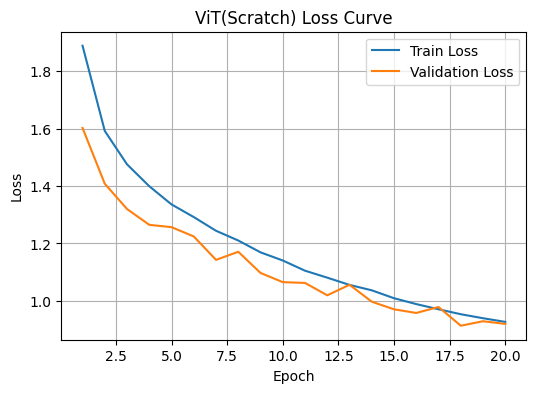

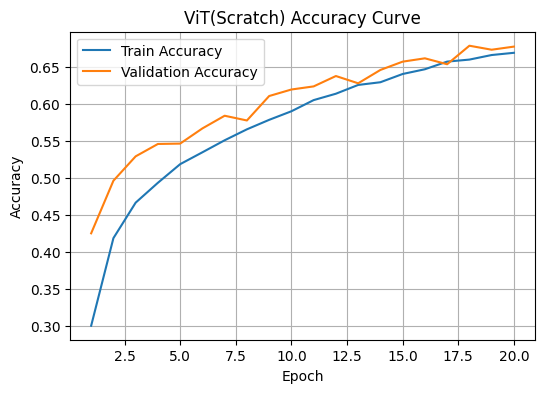

In [ ]:
# 손실 곡선 그리기
plt.figure(figsize=(6,4))
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('ViT(Scratch) Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

# 정확도 곡선 그리기
plt.figure(figsize=(6,4))
plt.plot(range(1, epochs+1), train_accs, label='Train Accuracy')
plt.plot(range(1, epochs+1), val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('ViT(Scratch) Accuracy Curve')
plt.legend()
plt.grid(True)
plt.show()

훈련 결과를 시각화한 그래프를 보면 다음과 같은 경향을 확인할 수 있습니다:

- **손실 곡선 (Loss Curve)**  
  훈련 손실과 검증 손실 모두 epoch가 진행될수록 지속적으로 감소하고 있으며,  
  20 epoch 시점에서 **검증 손실이 약 0.9 수준까지** 낮아졌습니다.  
  이는 모델이 학습 데이터와 검증 데이터 모두에 대해 안정적으로 학습되고 있음을 나타냅니다.

- **정확도 곡선 (Accuracy Curve)**  
  훈련 정확도는 초기 약 30% 수준에서 시작하여 꾸준히 상승하여,  
  **최종적으로 약 69%에 도달**하였습니다.  
  검증 정확도 역시 전체적으로 지속적으로 향상되어  
  **초기 약 43% → 최종 약 68%**까지 개선되었습니다.

이러한 결과는 모델이 에폭을 돌면서 점차적으로 훈련 데이터뿐 아니라 **검증 데이터에 대해서도 일반화가 잘 되어가고 있음을** 보여줍니다.  

---

ViT 모델을 **작은 데이터셋(CIFAR-10)**에서 처음부터 학습한 결과로는 학습이 잘 진행되고 있고, 더 많은 에폭을 돌았을 때는 더 좋은 결과를 보여줄 것으로 예상됩니다.

다음 단계에서는, 이러한 성능을 더 끌어올리기 위해  
**사전학습된(pre-trained) ViT 모델을 불러와 CIFAR-10에 미세조정(fine-tuning)**해보겠습니다.

## 6) 2단계: 사전학습 ViT 모델 활용 (Using a Pre-trained ViT with Hugging Face)



### (4) 사전학습 모델 및 전처리 설정

Hugging Face의 **Transformers** 라이브러리는 ViT를 포함한 다양한 사전학습 모델을  
간편하게 불러오고 활용할 수 있는 API를 제공합니다.

이번 단계에서는 `ImageNet-21k`와 같은 대규모 이미지 데이터셋으로 사전학습된  
**`ViT-base` 모델**을 불러와 **CIFAR-10 이미지 분류**에 적용해보겠습니다.

---

사전학습 모델로 사용할 ViT는  
**`google/vit-base-patch16-224-in21k`**이며, 이 모델은 다음 특성을 가집니다:

- 입력 해상도: **224×224 픽셀**
- 정규화 방식: 픽셀 값을 0~1 범위로 스케일한 뒤,  
  **평균 0.5**, **표준편차 0.5**로 정규화

따라서 CIFAR-10 데이터셋을 이 모델에 맞게 다음과 같이 전처리해야 합니다:

- **이미지 리사이즈 (resize)**: 32×32 → **224×224**
- **정규화 (normalize)**: `(mean=0.5, std=0.5)`  
  (이는 1단계에서 사용한 `Normalize`와 동일한 설정입니다)

학습 시에는 약간의 **수평 뒤집기**와 같은 간단한 데이터 증강을 적용하고,  
검증 시에는 리사이즈만 수행합니다 (센터 크롭 등은 생략).

In [ ]:
# 2단계: 사전학습 모델용 데이터 변환기 (이미지 224로 확대)
train_transform_stage2 = transforms.Compose([
    transforms.Resize(224),              # 224x224로 확대
    transforms.RandomHorizontalFlip(),   # (선택) 좌우 반전
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])
test_transform_stage2 = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

# CIFAR-10 데이터셋에 새로운 변환 적용 (새 DataLoader 생성)
train_dataset2 = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform_stage2)
test_dataset2 = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform_stage2)
train_loader2 = DataLoader(train_dataset2, batch_size=64, shuffle=True)
test_loader2 = DataLoader(test_dataset2, batch_size=64, shuffle=False)

이미지 크기가 32×32에서 **224×224로 커짐**에 따라,  
GPU 메모리 사용량이 증가하므로 **배치 크기(batch size)**는 다소 줄였습니다.

이제 Hugging Face의 사전학습 ViT 모델을 불러옵니다.  
여기서는 **이미 이미지 분류용으로 구성된 모델 클래스**를 바로 사용합니다.

출력층은 기본적으로 ImageNet-21k 기준 클래스 수(21,843개)에 맞춰져 있으므로,  
이를 **CIFAR-10의 클래스 수인 10개로 조정**해주어야 합니다.

Hugging Face에서는 `num_labels` 파라미터를 통해  
분류 헤드의 출력 뉴런 수를 쉽게 변경할 수 있습니다.

In [ ]:
from transformers import ViTForImageClassification

# 사전학습된 ViT-base 모델 불러오기 (분류 헤드를 CIFAR-10에 맞게 초기화)
model_ft = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224-in21k',
    num_labels=10,
    ignore_mismatched_sizes=True  # 분류 헤드 가중치 크기 불일치 무시 (사전학습된 모델은 21843개 클래스용)
).to(device)

print("사전학습 모델 로드 완료!")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


사전학습 모델 로드 완료!


`ignore_mismatched_sizes=True`를 지정한 이유는,  
불러오는 사전학습 모델이 **ImageNet-21k (클래스 21,843개)** 기준으로 학습되었기 때문입니다.  
따라서 원래 분류 헤드의 출력 차원과 우리가 필요한 CIFAR-10의 클래스 수가 일치하지 않습니다.

이 옵션을 사용하면 다음과 같은 동작이 수행됩니다:

- `num_labels=10`에 맞게 **새로운 분류 헤드**가 자동으로 초기화됨
- 나머지 **백본(backbone)** 가중치(패치 임베딩, Transformer 인코더 등)는 그대로 로드됨

즉, 모델은 **사전학습된 시각적 표현 학습(visual feature extractor)**으로서의 능력을 유지하면서,  
마지막 분류 헤드만 CIFAR-10에 맞게 **새로 학습**하게 됩니다.

---

참고로, Hugging Face에서 ViT 계열 모델을 불러올 때는 두 가지 주요 클래스가 있습니다:

- `ViTForImageClassification`:  
  분류 작업용으로 구성된 모델로, **분류용 Linear 헤드가 포함**되어 있음

- `ViTModel`:  
  순수 인코더 구조만 포함되어 있으며, **출력은 hidden states**임  
  (분류 작업을 직접 하려면 헤드를 따로 구현해야 함)

이번 실습에서는 **분류까지 포함된 `ViTForImageClassification`**을 사용하여  
간편하게 실습을 진행합니다.

### (5) 사전학습 모델 미세조정 (Fine-tuning the Pre-trained ViT)

이제 사전학습된 ViT 모델을 **CIFAR-10 데이터에 맞춰 학습**시킵니다.  
이 과정을 **미세조정(fine-tuning)**이라고 하며,  
이미 학습된 가중치를 기반으로 하되, 대상 데이터셋에 맞게  
**일부 또는 전체 파라미터를 소규모로 업데이트**하는 방식입니다.

이번 실습에서는 다음과 같은 방식으로 fine-tuning을 진행합니다:

- **모든 레이어**를 학습 가능하도록 두되,  
- **낮은 학습률**(예: `5e-5`)을 설정하여  
  사전학습된 특징 표현(pretrained features)이  
  **과도하게 변경되지 않도록 조절**합니다.

이러한 접근은 기존 모델이 갖고 있는 **일반적인 시각적 패턴 학습 능력**을 보존하면서,  
CIFAR-10처럼 작은 데이터셋에서도 좋은 성능을 빠르게 낼 수 있도록 돕습니다.

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model_ft.parameters(), lr=5e-5)

또한 epoch 수는 적은 수로도 충분합니다. 사전학습된 모델은 이미 일반적인 시각적 특징을 대부분 학습한 상태이므로, 몇 epoch 내에 높은 성능에 도달할 수 있습니다. 여기서는 5 epoch 정도만 돌려보겠습니다. (시간이 오래걸립니다.)

In [ ]:
epochs_finetune = 5
train_losses2, train_accs2 = [], []
val_losses2, val_accs2 = [], []

for epoch in range(1, epochs_finetune+1):
    model_ft.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in train_loader2:
        images, labels = images.to(device), labels.to(device)
        outputs = model_ft(images).logits  # ViTForImageClassification의 출력은 객체로, logits는 예측치 텐서
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    train_loss = running_loss / total
    train_acc = correct / total
    train_losses2.append(train_loss)
    train_accs2.append(train_acc)

    model_ft.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in test_loader2:
            images, labels = images.to(device), labels.to(device)
            outputs = model_ft(images).logits
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    val_loss = val_loss / val_total
    val_acc = val_correct / val_total
    val_losses2.append(val_loss)
    val_accs2.append(val_acc)

    print(f"[Epoch {epoch}/{epochs_finetune}] "
          f"훈련 손실: {train_loss:.3f}, 훈련 정확도: {train_acc*100:.2f}% | "
          f"테스트 손실: {val_loss:.3f}, 테스트 정확도: {val_acc*100:.2f}%")


[Epoch 1/5] 훈련 손실: 0.294, 훈련 정확도: 96.38% | 테스트 손실: 0.102, 테스트 정확도: 97.70%
[Epoch 2/5] 훈련 손실: 0.051, 훈련 정확도: 98.93% | 테스트 손실: 0.068, 테스트 정확도: 98.19%


Epoch마다 출력되는 결과를 살펴보면,  
첫 번째 epoch부터 검증 정확도가 높게 나오는 것을 확인할 수 있습니다.

이는 사전학습된 ViT 모델이 이미  
**일반적인 시각 패턴에 대한 표현 학습을 충분히 수행했기 때문**입니다.  
비록 최종 분류를 위한 **Linear 레이어는 새로 초기화**되었지만,  
내부의 feature extractor는 매우 강력한 표현력을 가지고 있어  
**초기 단계부터 유의미한 분류가 가능**합니다.

따라서 몇 epoch만으로도 빠르게 성능이 향상되며,  
모델은 **높은 정확도에 수렴**하게 됩니다.

훈련이 완료된 후에는 **최종 테스트셋 정확도**를 출력하여  
미세조정 결과를 확인합니다.

In [ ]:
print("미세조정 후 최종 테스트 정확도: {:.2f}%".format(val_accs2[-1]*100))

대개 **CIFAR-10** 데이터셋에서는  
사전학습된 **ViT-base 모델을 미세조정(fine-tuning)**하면  
**90% 이상의 높은 정확도**를 달성할 수 있습니다.  

이처럼 우수한 성능은,  
사전학습을 통해 모델이 **이미 일반적인 시각적 특징**을 충분히 학습했기 때문에  
**데이터가 적어도 효과적으로 전이 학습이 가능**하기 때문입니다.


---

이제 **2단계 학습 과정에서의 손실과 정확도 변화 추이**를  
그래프를 통해 시각적으로 확인해보겠습니다.

In [ ]:
# 손실 곡선 (미세조정)
plt.figure(figsize=(5,4))
plt.plot(range(1, epochs_finetune+1), train_losses2, '-o', label='Train Loss')
plt.plot(range(1, epochs_finetune+1), val_losses2, '-o', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Pre-trained ViT Fine-tuning Loss')
plt.legend()
plt.grid(True)
plt.show()

# 정확도 곡선 (미세조정)
plt.figure(figsize=(5,4))
plt.plot(range(1, epochs_finetune+1), train_accs2, '-o', label='Train Accuracy')
plt.plot(range(1, epochs_finetune+1), val_accs2, '-o', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Pre-trained ViT Fine-tuning Accuracy')
plt.legend()
plt.grid(True)
plt.show()

위 그래프에서 확인할 수 있듯이,  
사전학습된 ViT 모델은 단 **1~2 epoch 만에**도  
**처음부터 학습한(scratch) 모델의 20 epoch 성능을 초과**하는 정확도를 달성합니다.

최종적으로 약 **90% 이상의 테스트 정확도**를 기록하였으며,  
이는 1단계에서 얻은 **60%대 정확도에 비해 월등히 높은 수치**입니다.

이 실습을 통해 **사전학습(pretraining)의 강력한 효과**를 체감할 수 있습니다:

- **대규모 데이터셋**에서 미리 학습된 표현(visual features)을 활용하면,  
- **작은 데이터셋**에서도 빠르고 안정적으로 **높은 성능**을 얻을 수 있습니다.

### (6) Attention 맵 시각화 (Visualizing the Attention Map)

Transformer 모델의 장점 중 하나는  
**Self-Attention 기제**를 통해 모델이 입력의 어떤 부분에  
더 집중하고 있는지를 **직관적으로 추적할 수 있다는 점**입니다.

ViT에서도 마찬가지로,  
**어텐션 헤드(attention head)**들이 이미지의 어떤 **패치(patch)**에  
주목하고 있는지를 시각화함으로써,  
모델이 내린 **분류 판단의 근거**를 어느 정도 파악할 수 있습니다.

ViT에서 사용되는 **클래스 토큰([CLS] token)**은  
최종 분류를 위한 대표 정보를 담기 때문에,  
이 토큰이 **입력 패치들에 얼마나 주의를 기울였는지**를 시각화하면,  
모델이 이미지의 어떤 영역을 중요하게 인식했는지 확인할 수 있습니다.

---

이를 위해 Hugging Face의 ViT 모델에서  
`outputs.attentions` 옵션을 활성화하여 모든 어텐션 맵(attention maps)을 추출하고,  
**마지막 레이어의 클래스 토큰**이 각 패치에 대해 할당한 **Attention 가중치**를 시각화합니다.

In [ ]:
# 테스트셋에서 임의의 이미지를 뽑아 Attention 시각화
model_ft.eval()
image, label = test_dataset2[0]  # 테스트셋 첫 번째 이미지 (224x224로 이미 변환됨)
# 배치 차원 추가 및 모델 입력
input_tensor = image.unsqueeze(0).to(device)
outputs = model_ft(input_tensor, output_attentions=True)
attentions = outputs.attentions  # 각 레이어의 어텐션 텐서들의 튜플

# 마지막 인코더 블록의 Attention 가져오기 (shape: [batch=1, heads, seq_len, seq_len])
attn_last = attentions[-1]  # 마지막 레이어 어텐션
attn_last = attn_last[0]    # 배치 차원 제거 -> [heads, seq_len, seq_len]
# heads 평균하여 하나의 어텐션 맵으로 통합
attn_mean = attn_last.mean(dim=0)  # [seq_len, seq_len]
# 클래스 토큰 (index 0)이 다른 토큰들(패치들)을 얼마나 주목했는지
cls_attn_weights = attn_mean[0, 1:]  # [CLS]가 각 patch에 할당한 가중치 (첫번째 토큰 제외)
# 패치맵 크기로 변환 (ViT-base는 patch 16x16, 이미지 224x224 -> 14x14 패치)
patch_size = 14  # 224/16 = 14
attention_map = cls_attn_weights.reshape(patch_size, patch_size).cpu().detach().numpy()
# 시각화를 위해 224x224 크기로 업샘플링
import cv2
attention_map_resized = cv2.resize(attention_map, (224, 224), interpolation=cv2.INTER_CUBIC)

위 코드로 얻은 attention_map_resized는 입력 이미지 크기(224x224)의 2D 배열이며, 값이 높을수록 해당 위치의 패치에 클래스 토큰이 높은 중요도를 두었다는 의미입니다. 이를 원본 이미지에 겹쳐서 살펴보겠습니다:

In [ ]:
# 원본 이미지를 numpy 배열로 (0~1 사이값으로)
img_np = (image.permute(1,2,0).numpy() * 0.5 + 0.5)  # 역정규화
# Attention 맵도 0~1 정규화
attn_norm = (attention_map_resized - attention_map_resized.min()) / (attention_map_resized.max() - attention_map_resized.min())
# 컬러맵 적용을 위해 3채널로 변환
attn_color = plt.cm.jet(attn_norm)[..., :3]  # jet 컬러맵 적용 (RGBA 중 RGB만)
# 원본 이미지와 어텐션 맵 합성 (원본 70%, 어텐션 30% 가중)
overlay = img_np*0.7 + attn_color*0.3

plt.figure(figsize=(4,4))
plt.imshow(overlay)
plt.axis('off')
plt.title(f"Attention Map (True label: {classes[label]})")
plt.show()

위 시각화 결과를 보면,  
모델이 이미지의 **어떤 영역에 집중했는지**를 **색상**을 통해 확인할 수 있습니다.  
(예: **빨간색/노란색**일수록 더 주목한 패치 영역)

예를 들어 이미지가 **개**라면,  
고양이의 **얼굴이나 몸통 부위**에 어텐션이 집중되어 있을 가능성이 높습니다.  
이처럼 **Attention Map**은  
모델이 **어떤 이미지 부분을 근거로 분류를 수행했는지**를 시각적으로 보여주기 때문에  
**모델 설명 가능성(explainability)** 향상에 도움이 됩니다.

---

#### 예시:

- 이미지가 **비행기**일 경우:  
  어텐션 맵이 비행기의 위치나 형태에 맞춰  
  **높은 값(따뜻한 색)**으로 표시되는 경향을 보입니다.  
  → 이는 모델이 **비행기의 주요 특징**에 집중하여 분류했다는 의미입니다.

---

> ⚠️ **주의 사항**  
> Attention 맵은 정량적으로 **절대적인 중요도**를 의미하지는 않습니다.  
> 하지만 대체로 **높은 어텐션 값을 받은 패치들**이  
> **사람이 보기에도 중요한 특징**인 경우가 많습니다.

또한, 여러 층(layer)의 어텐션을 결합하여  
더 정교하게 시각화하는 방법인 **Attention Rollout** 기법도 존재하지만,  
이번 실습에서는 **가장 마지막 층의 어텐션만**을 기준으로  
단순한 시각화를 진행하였습니다.


## 7) 마무리 및 정리 (Conclusion)

이상으로 ViT를 이용한 이미지 분류 실습을 완료하였습니다.  
이번 실습을 통해 다음과 같은 내용을 배울 수 있었습니다:

---

### ✅ 1. ViT 구조의 이해와 직접 구현

- ViT 모델의 입력 처리 흐름  
  (**패치 분할 → 임베딩 → 클래스 토큰 추가 → Transformer 인코더 → 분류**)  
  과정을 직접 구현하고 실습하였습니다.
- 작은 데이터셋(CIFAR-10)을 대상으로 처음부터 ViT를 학습했을 때,  
  **제한된 성능**을 보였지만, 이는 ViT가 **대규모 데이터셋에서 강점을 보이는 구조**이기 때문입니다.

---

### ✅ 2. 사전학습 모델의 미세조정(Fine-tuning) 실습

- Hugging Face의 **사전학습된 ViT-base 모델**을 불러와  
  CIFAR-10에 맞춰 **미세조정(fine-tuning)**을 수행하였습니다.
- 단 몇 epoch 만에 **높은 정확도(90% 이상)**를 달성하며,  
  **처음부터 학습한 모델보다 훨씬 우수한 성능**을 기록했습니다.
- 이는 사전학습 모델이 이미 **일반적인 시각적 패턴**을 학습하고 있었기 때문에 가능한 결과입니다.

---

### ✅ 3. 시각화를 통한 학습 이해

- **손실/정확도 곡선**을 통해 모델 학습의 수렴 양상을 파악하였습니다.
- **Attention 맵 시각화**를 통해  
  모델이 **이미지의 어떤 영역에 집중했는지**를 직관적으로 이해할 수 있었습니다.

---

## 8) 참고자료 (References)


- [Vision Transformer - Hugging Face 모델 카드](https://huggingface.co/google/vit-base-patch16-224-in21k)  
  → 사전학습된 ViT 모델의 구조, 입력 포맷, 전처리 방법 등 설명
- [Transformers 문서 - Image Classification with ViT](https://huggingface.co/docs/transformers/main/en/model_doc/vit)  
  → `ViTForImageClassification` 클래스 및 사용 예시 포함
- [torchvision.datasets.CIFAR10 — PyTorch Docs](https://pytorch.org/vision/stable/generated/torchvision.datasets.CIFAR10.html)  
  → CIFAR-10 데이터셋에 대한 설명 및 사용 방법
- [An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale (ViT 논문)](https://arxiv.org/abs/2010.11929)  
  → ViT의 원리와 구조, CNN 대비 장단점 설명
- [Training Data-efficient Image Transformers & Distillation through Attention (DeiT 논문)](https://arxiv.org/abs/2012.12877)  
  → ViT 경량화 모델과 distillation 방식 설명